In [56]:
import torch
import torchvision
import numpy as np
from skimage import io, transform
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

np.random.seed(seed:=69)
torch.manual_seed(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from warnings import filterwarnings
filterwarnings('ignore')
plt.ion() # interactive mode

In [5]:
path = 'E:\\Vision\\faces\\'
data_path = path + 'face_landmarks.csv'
target_path = path + 'create_landmark_dataset.py'

In [6]:
landmarks_frame = pd.read_csv(data_path)

In [12]:
m = landmarks_frame.shape[0]
print(f'Number of samples: {m}')
landmarks_frame.head()

Number of samples: 69


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [16]:
n = np.random.randint(0, m)
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float)
landmarks = landmarks.reshape(-1, 2)

print(f'Image {n} name: {img_name}')
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 landmarks: {}'.format(landmarks[:4]))

Image 55 name: 3872768751_e60d7fdbd5.jpg
Landmarks shape: (68, 2)
First 4 landmarks: [[268. 110.]
 [271. 124.]
 [277. 136.]
 [283. 148.]]


In [19]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.00001) # pause so the plots are updated

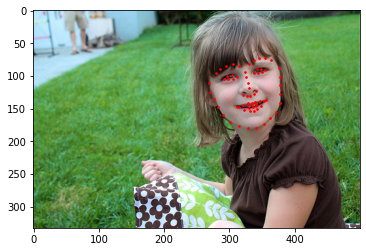

In [20]:
plt.figure()
show_landmarks(io.imread(os.path.join(path, img_name)), landmarks)
plt.show()

In [25]:
# torch.utils.data.Dataset is an abstract class representing a dataset. 
# Your custom dataset should inherit Dataset and override the following methods:
# __len__ so that len(dataset) returns the size of the dataset.
# __getitem__ to support the indexing such that dataset[i] can be used to get ith sample
# Let’s create a dataset class for our face landmarks dataset. 
# We will read the csv in __init__ but leave the reading of images to __getitem__. 
# This is memory efficient because all the images are not stored in the memory at once but read as required.
# Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. 
# Our dataset will take an optional argument transform so that any required processing can be applied on the sample. 
# We will see the usefulness of transform in the next section.

In [34]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, 
                               self.landmarks_frame.iloc[idx, 0])
        img = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.asarray(landmarks, dtype=float).reshape(-1,2)
        sample = {'image':img, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

sample 0 shape: (324, 215, 3) (68, 2)


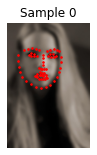

sample 1 shape: (500, 333, 3) (68, 2)


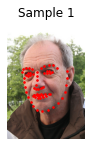

sample 2 shape: (250, 258, 3) (68, 2)


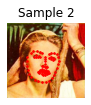

sample 3 shape: (434, 290, 3) (68, 2)


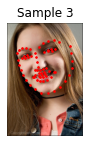

In [42]:
face_dataset = FaceLandmarksDataset(csv_file=data_path, root_dir=path, transform=None)
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(f'sample {i} shape: {sample["image"].shape} {sample["landmarks"].shape}')
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample {i}')
    ax.axis('off')
    show_landmarks(**sample)
    
    if i + 1 == 4:
        plt.show()
        break

In [43]:
# One issue we can see from the above is that the samples are not of the same size. 
# Most neural networks expect the images of a fixed size. 
# Therefore, we will need to write some prepocessing code. 
# Let’s create three transforms:

# Rescale: to scale the image
# RandomCrop: to crop from image randomly. This is data augmentation.
# ToTensor: to convert the numpy images to torch images (we need to swap axes).
# We will write them as callable classes instead of simple functions so that parameters of 
# the transform need not be passed everytime it’s called. For this, we just need to 
# implement __call__ method and if required, __init__ method. 
# We can then use a transform like this:

# tsfm = Transform(params)
# transformed_sample = tsfm(sample)

In [64]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images, 
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

In [69]:
class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        assert len(self.output_size) == 2
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        new_h, new_w = self.output_size
        h, w = image.shape[:2]
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

In [82]:
class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because:
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).to(device), 
                'landmarks': torch.from_numpy(landmarks).to(device)}

In [83]:
# Now, we apply the transforms on a sample.
# Let’s say we want to rescale the shorter side of the image to 256 and then 
# randomly crop a square of size 224 from it. i.e, we want to 
# compose Rescale and RandomCrop transforms. 
# torchvision.transforms.Compose is a simple callable class which allows us to do this.

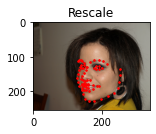

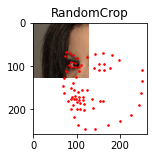

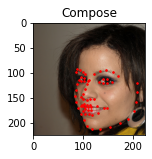

In [84]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# apply each transform on a sample
fig = plt.figure()
i = np.random.randint(0, len(face_dataset))
sample = face_dataset[i]
for i, trans in enumerate([scale, crop, composed]):
    transformed_sample = trans(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(trans).__name__)
    show_landmarks(**transformed_sample)
plt.show()

In [85]:
# Iterating through the dataset
# Let’s put this all together to create a dataset with composed transforms. 
# To summarize, every time this dataset is sampled:

# An image is read from the file on the fly
# Transforms are applied on the read image
# Since one of the transforms is random, data is augmentated on sampling
# We can iterate over the created dataset with a for i in range loop as before.

In [86]:
transformed_dataset = FaceLandmarksDataset(csv_file=data_path, root_dir=path,
                                          transform=transforms.Compose([
                                              Rescale(256),
                                              RandomCrop(254),
                                              ToTensor()
                                          ]))

In [87]:
for i in range(min(len(transformed_dataset), 3)):
    sample = transformed_dataset[i]
    print(f"{i} {sample['image'].size()} {sample['landmarks'].size()}")

0 torch.Size([3, 254, 254]) torch.Size([68, 2])
1 torch.Size([3, 254, 254]) torch.Size([68, 2])
2 torch.Size([3, 254, 254]) torch.Size([68, 2])


In [89]:
# However, we are losing a lot of features by using a simple 
# for loop to iterate over the data. 
# In particular, we are missing out on:
# Batching the data
# Shuffling the data
# Load the data in parallel using multiprocessing workers.

# torch.utils.data.DataLoader is an iterator which provides all these features. 
# Parameters used below should be clear. 
# One parameter of interest is collate_fn. 
# You can specify how exactly the samples need to be batched using collate_fn. 
# However, default collate should work fine for most use cases.

In [96]:
batch_size = 4
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=0)

# helper function to show a batch
def show_landmarks_batch(sample_batched):
    """show image with landmarks for a batch of samples"""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.to('cpu').numpy().transpose((1, 2, 0))) # invert our transpose
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].to('cpu').numpy() + 
                    i * im_size + (i + 1) * grid_border_size,
                   landmarks_batch[i, :, 1].to('cpu').numpy() + 
                    grid_border_size, s=10, marker='.', c='r')
        plt.title('Batch from DataLoader')

0 torch.Size([4, 3, 254, 254]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 254, 254]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 254, 254]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 254, 254]) torch.Size([4, 68, 2])


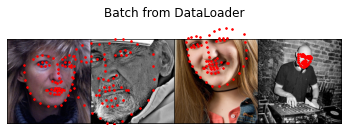

In [97]:
for i, sample_batched in enumerate(dataloader):
    print(i, sample_batched['image'].size(), sample_batched['landmarks'].size())
    
    if i > 2:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break